In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, LSTM, Dense, MaxPooling1D, Conv1D, UpSampling1D, Reshape, TimeDistributed, Bidirectional

# Constants
INPUT_FEATURES = 26                # Number of input features (e.g., temperature, humidity, etc.)
SEQUENCE_LEN = 7 * 24              # 7 days of hourly data
OUTPUT_LEN = 1 * 24                # 24 hours in the next day
OUTPUT_FEATURES = 3 * OUTPUT_LEN   # Predicting 3 features for each day
LSTM_UNITS = 128                   # Number of LSTM units
DENSE_UNITS = 128                   # Number of Dense layer units
DROPOUT_RATE = 0.2                 # Dropout rate

In [2]:
data = pd.read_csv('../data/preprocessed_data/complete_krk_2017-22.csv')
data = data.drop('timestamp', axis=1)
cols = data.columns

In [3]:
# Assuming 'data' is your dataset with shape (total_hours, 26_features)
# and 'total_hours' is a multiple of 24

# Normalize your data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
data_normalized

array([[-1.84487084,  0.96334401, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-1.85603007,  0.93829589, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-1.52125303,  0.85062749, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       ...,
       [-0.14866714,  0.43733359, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-0.04823402,  0.43733359, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-0.40532954,  0.42480953, -0.13402178, ..., -0.15217187,
        -0.12556201, -0.28491282]])

In [4]:
# Function to create sequences
def create_sequences(data):
    X, y = [], []
    for i in range(len(data) - SEQUENCE_LEN - OUTPUT_LEN):
        X.append(data[i: i + SEQUENCE_LEN])
        y.append(data[i + SEQUENCE_LEN: i + SEQUENCE_LEN + OUTPUT_LEN, :3]) # Taking the first 3 features for the next 24 hours
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(data_normalized)

In [5]:
train_size = 24 * (365 * 3 + 366)
val_size = 24 * 365

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [28]:
from keras.optimizers import SGD, Adam

# Input layer
input_layer = Input(shape=(168, 26))  # 7 days * 24 hours, 26 parameters

reshape = Reshape((26, 168)) (input_layer)
# Downsampling
conv1 = Conv1D(filters=102, kernel_size=7, activation='relu', strides=1, padding="causal") (reshape)
lstm1 = Bidirectional(LSTM(102, return_sequences=True))(conv1)

lstm2 = Bidirectional(LSTM(48, return_sequences=False))(lstm1)

# Output layer
output_layer = Dense(72, activation='linear') (lstm2)

# Build the model
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust optimizer and loss as needed
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 168, 26)]         0         
                                                                 
 reshape_1 (Reshape)         (None, 26, 168)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 102)           120054    
                                                                 
 bidirectional_2 (Bidirecti  (None, 26, 204)           167280    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 96)                97152     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 72)                6984

In [29]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
548/548 [==============================] - 52s 84ms/step - loss: 0.4741 - val_loss: 0.4164
Epoch 2/10
548/548 [==============================] - 50s 91ms/step - loss: 0.3968 - val_loss: 0.4320
Epoch 3/10
548/548 [==============================] - 49s 89ms/step - loss: 0.3573 - val_loss: 0.4352
Epoch 4/10
548/548 [==============================] - 45s 83ms/step - loss: 0.3330 - val_loss: 0.4319
Epoch 5/10
548/548 [==============================] - 47s 87ms/step - loss: 0.3167 - val_loss: 0.4411
Epoch 6/10
548/548 [==============================] - 47s 86ms/step - loss: 0.3019 - val_loss: 0.4419
Epoch 7/10
548/548 [==============================] - 47s 85ms/step - loss: 0.2948 - val_loss: 0.4421
Epoch 8/10
548/548 [==============================] - 48s 88ms/step - loss: 0.2930 - val_loss: 0.4403
Epoch 9/10
548/548 [==============================] - 47s 86ms/step - loss: 0.2827 - val_loss: 0.4446
Epoch 10/10
548/548 [==============================] - 48s 88ms/step - loss: 0.274

In [30]:
# Make predictions
y_pred = model.predict(X_test)


268/268 [==============================] - 6s 16ms/step


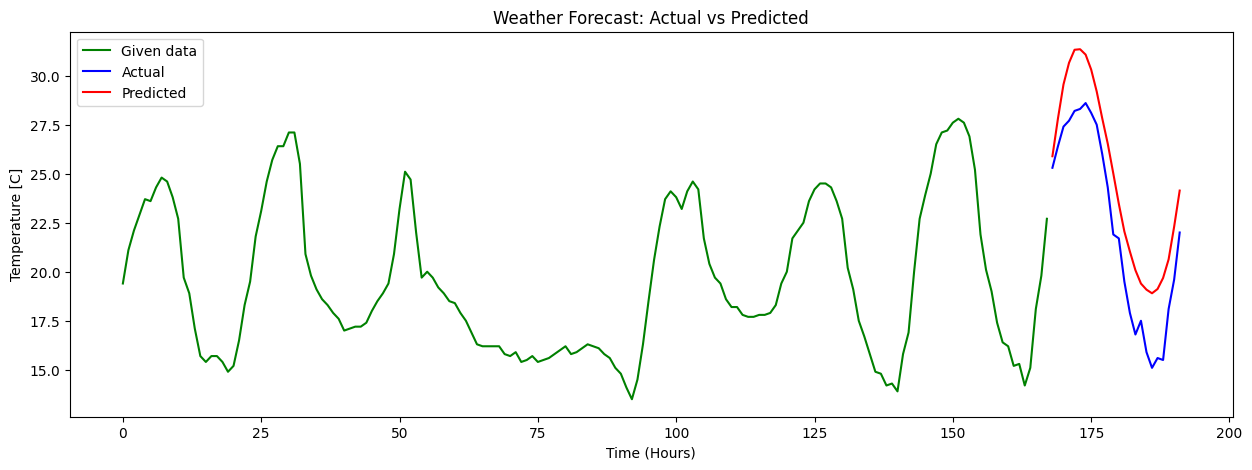

In [35]:
IDX = 5000  # choose number of prediction
labels = ['Temperature [C]', 'Pressure [hPa]', 'Rainfall [mm]']
P = 0      # parameter (0 - Temp, 1 - pressure, 2 - rain)

x = range(0, SEQUENCE_LEN + OUTPUT_LEN)
x1, x2 = x[:SEQUENCE_LEN], x[SEQUENCE_LEN:]
std, mean = scaler.scale_[P], scaler.mean_[P]

# Plotting
plt.figure(figsize=(15, 5))

plt.plot(x1, X_test[IDX, :, P] * std + mean, label='Given data', color='green')
plt.plot(x2, y_test[:, P::3][IDX] * std + mean, label='Actual', color='blue')
plt.plot(x2, y_pred[:, P::3][IDX] * std + mean, label='Predicted', color='red')

# Labeling the plot
plt.title('Weather Forecast: Actual vs Predicted')
plt.xlabel('Time (Hours)')
plt.ylabel(labels[P])
plt.legend()
plt.show()